<a href="https://colab.research.google.com/github/victorbahlangene/fastai-fastbook22/blob/main/07_how_random_forests_really_work_recreaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In [1]:
from fastai.imports import *
np.set_printoptions(linewidth=130)

# Data preproccesing

In [ ]:
# to use kaggle api #
!pip install kaggle

# kaggle API creds #
creds = '{"username":"victorbahlangene","key":"2cd1abe2f1c35ea3060e6a2f18a055ea"}'

from pathlib import Path

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [4]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle: path = Path('../input/titanic')
else:
    import zipfile,kaggle
    path = Path('titanic')
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

df = pd.read_csv(path/'train.csv')
tst_df = pd.read_csv(path/'test.csv')
modes = df.mode().iloc[0]

100%|██████████| 34.1k/34.1k [00:00<00:00, 21.0MB/s]

In [6]:
path.ls()

(#3) [Path('titanic/train.csv'),Path('titanic/gender_submission.csv'),Path('titanic/test.csv')]

In [8]:
cont_cat_split??

Object `cont_cat_split` not found.


In [9]:
df = pd.read_csv(path/'train.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [37]:
tst_df = pd.read_csv(path/'test.csv')
tst_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [13]:
from fastai.tabular.all import *

In [18]:
cont_cat_split??

In [26]:
dep_var = "Survived"

look at default categorical cols

In [27]:
cont, cat = cont_cat_split(df, dep_var=dep_var)

In [28]:
cont

['PassengerId', 'Age', 'Fare']

In [29]:
cat

['Pclass', 'Name', 'Sex', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked']

categorical data

In [32]:
pd.Categorical??

In [33]:
df[cat].head()

,Pclass,Name,Sex,SibSp,Parch,Ticket,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,1,0,A/5 21171,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,1,0,PC 17599,C85,C
2,3,"Heikkinen, Miss. Laina",female,0,0,STON/O2. 3101282,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,1,0,113803,C123,S
4,3,"Allen, Mr. William Henry",male,0,0,373450,NaN,S


In [38]:
cat

['Pclass', 'Name', 'Sex', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked']

mode of data frame

In [43]:
modes = df.mode().iloc[0]

In [44]:
def proc_data(df):
  df['Fare'] = df.Fare.fillna(0)
  df.fillna(modes, inplace=True)
  df['LogFare'] = np.log1p(df['Fare'])
  df['Pclass'] = pd.Categorical(df.Pclass)  
  df['Name'] = pd.Categorical(df.Name)
  df['Sex'] = pd.Categorical(df.Sex)
  df['SibSp'] = pd.Categorical(df.SibSp)
  df['Parch'] = pd.Categorical(df.Parch)
  df['Ticket'] = pd.Categorical(df.Ticket)
  df['Cabin'] = pd.Categorical(df.Cabin)
  df['Embarked'] = pd.Categorical(df.Embarked)

In [45]:
proc_data(df)
proc_data(tst_df)

In [46]:
df['Embarked'].head()

0    S
1    C
2    S
3    S
4    S
Name: Embarked, dtype: category
Categories (3, object): ['C', 'Q', 'S']

In [51]:
df['Embarked'].cat.codes.head()

0    2
1    0
2    2
3    2
4    2
dtype: int8

In [48]:
cat

['Pclass', 'Name', 'Sex', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked']

In [49]:
cont

['PassengerId', 'Age', 'Fare']

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    category
 3   Name         891 non-null    category
 4   Sex          891 non-null    category
 5   Age          891 non-null    float64 
 6   SibSp        891 non-null    category
 7   Parch        891 non-null    category
 8   Ticket       891 non-null    category
 9   Fare         891 non-null    float64 
 10  Cabin        891 non-null    category
 11  Embarked     891 non-null    category
 12  LogFare      891 non-null    float64 
dtypes: category(8), float64(3), int64(2)
memory usage: 111.5 KB


In [54]:
splits = RandomSplitter(valid_pct=0.2, seed=42)(df)
splits

((#713) [788,525,821,253,374,98,215,313,281,305...],
 (#178) [303,778,531,385,134,476,691,443,386,128...])

In [55]:
to = TabularPandas (df,cat_names=cat, cont_names=cont,
                y_names=dep_var, y_block=CategoryBlock(), splits=splits)

In [62]:
procs = [Categorify, FillMissing, Normalize]

In [63]:
to1 = TabularPandas (df, procs=procs, cat_names=cat, cont_names=cont,
                y_names=dep_var, y_block=CategoryBlock(), splits=splits)

In [64]:
to1.show()

,Pclass,Name,Sex,SibSp,Parch,Ticket,Cabin,Embarked,PassengerId,Age,Fare,Survived
788,3,"Dean, Master. Bertram Vere",male,1,2,C.A. 2315,B96 B98,S,789.0,1.00,20.575001,1
525,3,"Farrell, Mr. James",male,0,0,367232,B96 B98,Q,526.0,40.50,7.750000,0
821,3,"Lulic, Mr. Nikola",male,0,0,315098,B96 B98,S,822.0,27.00,8.662500,1
253,3,"Lobb, Mr. William Arthur",male,1,0,A/5. 3336,B96 B98,S,254.0,30.00,16.100000,0
374,3,"Palsson, Miss. Stina Viola",female,3,1,349909,B96 B98,S,375.0,3.00,21.075001,0
98,2,"Doling, Mrs. John T (Ada Julia Bone)",female,0,1,231919,B96 B98,S,99.0,34.00,23.000000,1
215,1,"Newell, Miss. Madeleine",female,1,0,35273,D36,C,216.0,31.00,113.275002,1
313,3,"Hendekovic, Mr. Ignjac",male,0,0,349243,B96 B98,S,314.0,28.00,7.895800,0
281,3,"Olsson, Mr. Nils Johan Goransson",male,0,0,347464,B96 B98,S,282.0,28.00,7.854200,0
305,1,"Allison, Master. Hudson Trevor",male,1,2,113781,C22 C26,S,306.0,0.92,151.550003,1


In [65]:
to1.items

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare
788,1.324792,1,3,209,2,-2.092618,2,3,549,-0.226999,48,3,3.071535
525,0.310172,0,3,245,2,0.910474,1,1,447,-0.477002,48,2,2.169054
821,1.452102,1,3,494,2,-0.115899,1,1,270,-0.459214,48,3,2.268252
253,-0.739169,0,3,488,2,0.112184,2,1,537,-0.314232,48,3,2.839078
374,-0.272367,0,3,626,1,-1.940563,4,2,396,-0.217253,48,3,3.094446
...,...,...,...,...,...,...,...,...,...,...,...,...,...
770,1.255351,0,3,481,2,-0.343982,1,1,314,-0.442889,48,3,2.351375
414,-0.118052,1,3,793,2,1.176571,1,1,656,-0.473591,48,3,2.188856
540,0.368040,1,1,189,1,0.568350,1,3,681,0.755954,21,3,4.276666
298,-0.565565,1,1,715,2,-0.343982,1,1,99,-0.033528,52,3,3.449988


In [57]:
to.show()

,Pclass,Name,Sex,SibSp,Parch,Ticket,Cabin,Embarked,PassengerId,Age,Fare,Survived
788,3,"Dean, Master. Bertram Vere",male,1,2,C.A. 2315,B96 B98,S,789,1.00,20.575001,1
525,3,"Farrell, Mr. James",male,0,0,367232,B96 B98,Q,526,40.50,7.750000,0
821,3,"Lulic, Mr. Nikola",male,0,0,315098,B96 B98,S,822,27.00,8.662500,1
253,3,"Lobb, Mr. William Arthur",male,1,0,A/5. 3336,B96 B98,S,254,30.00,16.100000,0
374,3,"Palsson, Miss. Stina Viola",female,3,1,349909,B96 B98,S,375,3.00,21.075001,0
98,2,"Doling, Mrs. John T (Ada Julia Bone)",female,0,1,231919,B96 B98,S,99,34.00,23.000000,1
215,1,"Newell, Miss. Madeleine",female,1,0,35273,D36,C,216,31.00,113.275002,1
313,3,"Hendekovic, Mr. Ignjac",male,0,0,349243,B96 B98,S,314,28.00,7.895800,0
281,3,"Olsson, Mr. Nils Johan Goransson",male,0,0,347464,B96 B98,S,282,28.00,7.854200,0
305,1,"Allison, Master. Hudson Trevor",male,1,2,113781,C22 C26,S,306,0.92,151.550003,1


In [59]:
to.items

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare
788,789,1,3,"Dean, Master. Bertram Vere",male,1.0,1,2,C.A. 2315,20.575001,B96 B98,S,3.071535
525,526,0,3,"Farrell, Mr. James",male,40.5,0,0,367232,7.750000,B96 B98,Q,2.169054
821,822,1,3,"Lulic, Mr. Nikola",male,27.0,0,0,315098,8.662500,B96 B98,S,2.268252
253,254,0,3,"Lobb, Mr. William Arthur",male,30.0,1,0,A/5. 3336,16.100000,B96 B98,S,2.839078
374,375,0,3,"Palsson, Miss. Stina Viola",female,3.0,3,1,349909,21.075001,B96 B98,S,3.094446
...,...,...,...,...,...,...,...,...,...,...,...,...,...
770,771,0,3,"Lievens, Mr. Rene Aime",male,24.0,0,0,345781,9.500000,B96 B98,S,2.351375
414,415,1,3,"Sundman, Mr. Johan Julian",male,44.0,0,0,STON/O 2. 3101269,7.925000,B96 B98,S,2.188856
540,541,1,1,"Crosby, Miss. Harriet R",female,36.0,0,2,WE/P 5735,71.000000,B22,S,4.276666
298,299,1,1,"Saalfeld, Mr. Adolphe",male,24.0,0,0,19988,30.500000,C106,S,3.449988


In [58]:
len(to.train),len(to.valid)

(713, 178)

In [71]:
to.train.xs

,Pclass,Name,Sex,SibSp,Parch,Ticket,Cabin,Embarked,PassengerId,Age,Fare
788,3,"Dean, Master. Bertram Vere",male,1,2,C.A. 2315,B96 B98,S,789,1.0,20.575001
525,3,"Farrell, Mr. James",male,0,0,367232,B96 B98,Q,526,40.5,7.750000
821,3,"Lulic, Mr. Nikola",male,0,0,315098,B96 B98,S,822,27.0,8.662500
253,3,"Lobb, Mr. William Arthur",male,1,0,A/5. 3336,B96 B98,S,254,30.0,16.100000
374,3,"Palsson, Miss. Stina Viola",female,3,1,349909,B96 B98,S,375,3.0,21.075001
...,...,...,...,...,...,...,...,...,...,...,...
173,3,"Sivola, Mr. Antti Wilhelm",male,0,0,STON/O 2. 3101280,B96 B98,S,174,21.0,7.925000
462,1,"Gee, Mr. Arthur H",male,0,0,111320,E63,S,463,47.0,38.500000
358,3,"McGovern, Miss. Mary",female,0,0,330931,B96 B98,Q,359,24.0,7.879200
532,3,"Elias, Mr. Joseph Jr",male,1,1,2690,B96 B98,C,533,17.0,7.229200


In [72]:
to.train.y

788    1
525    0
821    1
253    0
374    0
      ..
173    0
462    0
358    1
532    0
344    0
Name: Survived, Length: 713, dtype: int8

In [73]:
to.valid.xs

,Pclass,Name,Sex,SibSp,Parch,Ticket,Cabin,Embarked,PassengerId,Age,Fare
303,2,"Keane, Miss. Nora A",female,0,0,226593,E101,Q,304,24.0,12.3500
778,3,"Kilgannon, Mr. Thomas J",male,0,0,36865,B96 B98,Q,779,24.0,7.7375
531,3,"Toufik, Mr. Nakli",male,0,0,2641,B96 B98,C,532,24.0,7.2292
385,2,"Davies, Mr. Charles Henry",male,0,0,S.O.C. 14879,B96 B98,S,386,18.0,73.5000
134,2,"Sobey, Mr. Samuel James Hayden",male,0,0,C.A. 29178,B96 B98,S,135,25.0,13.0000
...,...,...,...,...,...,...,...,...,...,...,...
770,3,"Lievens, Mr. Rene Aime",male,0,0,345781,B96 B98,S,771,24.0,9.5000
414,3,"Sundman, Mr. Johan Julian",male,0,0,STON/O 2. 3101269,B96 B98,S,415,44.0,7.9250
540,1,"Crosby, Miss. Harriet R",female,0,2,WE/P 5735,B22,S,541,36.0,71.0000
298,1,"Saalfeld, Mr. Adolphe",male,0,0,19988,C106,S,299,24.0,30.5000


In [74]:
to.valid.y

303    1
778    0
531    0
385    0
134    0
      ..
770    0
414    1
540    1
298    1
489    1
Name: Survived, Length: 178, dtype: int8

for object `to`

In [75]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

for object `to1`

In [76]:
xs1,y1 = to1.train.xs,to1.train.y
valid_xs1,valid_y1 = to1.valid.xs,to1.valid.y

# Random Forest

In [60]:
from sklearn.ensemble import RandomForestClassifier

In [61]:
from sklearn.metrics import accuracy_score
#accuracy_score(y_true, y_pred)

using obj `to`

In [77]:
rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(xs, y);
accuracy_score(valid_y, rf.predict(valid_xs))

ValueError: ignored

using obj `to1`

In [78]:
rf1 = RandomForestClassifier(100, min_samples_leaf=5)
rf1.fit(xs1, y1);
accuracy_score(valid_y1, rf1.predict(valid_xs1))

0.8426966292134831

better than the neral net in fastai22 chp 06

In [83]:
rf1.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

# Random Forest grid search

In [92]:
rfc_params={
 'bootstrap': [True,False],
 'max_features': ['auto','sqrt'],
 'min_samples_leaf': [4,5],
 'min_samples_split': [2,5],
 'n_estimators': [100,200]
}

In [85]:
# Using gridsearch to find the best params for SVC #
from sklearn.model_selection import GridSearchCV

In [94]:
# creating a gridsearch with random forest classifier #
grid_rcf = GridSearchCV(RandomForestClassifier(),rfc_params,verbose=3)

In [95]:
# fitting model to training data #
grid_rcf.fit(xs1, y1)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END bootstrap=True, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.860 total time=   0.2s
[CV 2/5] END bootstrap=True, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.762 total time=   0.2s
[CV 3/5] END bootstrap=True, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.832 total time=   0.2s
[CV 4/5] END bootstrap=True, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.817 total time=   0.2s
[CV 5/5] END bootstrap=True, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.859 total time=   0.2s
[CV 1/5] END bootstrap=True, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.846 total time=   0.4s
[CV 2/5] END bootstrap=True, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=20

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [4, 5],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             verbose=3)

In [96]:
grid_rcf.best_params_

{'bootstrap': True,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 100}

In [97]:
grid_rcf.best_estimator_

RandomForestClassifier(min_samples_leaf=4)

In [98]:
rf1.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [99]:
rf1

RandomForestClassifier(min_samples_leaf=5)

In [108]:
rf_with_grid = RandomForestClassifier(100, min_samples_leaf=1)
rf_with_grid.fit(xs1, y1);
accuracy_score(valid_y1, rf_with_grid.predict(valid_xs1))

0.8370786516853933

# feature_importances

In [109]:
xs1.columns

Index(['Pclass', 'Name', 'Sex', 'SibSp', 'Parch', 'Ticket', 'Cabin',
       'Embarked', 'PassengerId', 'Age', 'Fare'],
      dtype='object')

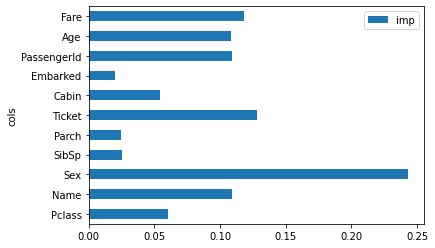

In [110]:
pd.DataFrame(dict(cols=xs1.columns, imp=rf_with_grid.feature_importances_)).plot('cols', 'imp', 'barh');

## Removing Low-Importance Variables

In [111]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [112]:
fi = rf_feat_importance(rf_with_grid, xs1)
fi

,cols,imp
2,Sex,0.242710
5,Ticket,0.128027
10,Fare,0.118065
1,Name,0.109174
8,PassengerId,0.108972
9,Age,0.108418
0,Pclass,0.060631
6,Cabin,0.053905
3,SibSp,0.025395
4,Parch,0.024753


In [113]:
to_keep = fi[fi.imp>0.05].cols
len(to_keep)

8

In [114]:
valid_xs1

,Pclass,Name,Sex,SibSp,Parch,Ticket,Cabin,Embarked,PassengerId,Age,Fare
303,2,429,1,1,1,110,117,2,-0.546276,-0.343982,-0.387332
778,3,439,2,1,1,451,48,2,1.286214,-0.343982,-0.477246
531,3,819,2,1,1,182,48,1,0.333319,-0.343982,-0.487154
385,2,206,2,1,1,622,48,3,-0.229930,-0.800148,0.804687
134,2,773,2,1,1,553,48,3,-1.198256,-0.267954,-0.374662
...,...,...,...,...,...,...,...,...,...,...,...
770,3,481,2,1,1,314,48,3,1.255351,-0.343982,-0.442889
414,3,793,2,1,1,656,48,3,-0.118052,1.176571,-0.473591
540,1,189,1,1,3,681,21,3,0.368040,0.568350,0.755954
298,1,715,2,1,1,99,52,3,-0.565565,-0.343982,-0.033528


In [115]:
xs_imp = xs1[to_keep]
valid_xs_imp = valid_xs1[to_keep]

In [119]:
def rfc(xs, y, n_estimators=100, min_samples_leaf=4):
  rf_with_grid = RandomForestClassifier(n_estimators=n_estimators, min_samples_leaf=min_samples_leaf)
  rf_with_grid.fit(xs1, y1);
  return accuracy_score(valid_y1, rf_with_grid.predict(valid_xs1))

In [121]:
acc = rfc(xs_imp,valid_xs_imp)
acc

0.8370786516853933

# Random forest Ensembling